# Project 1: Borrowers and Lenders

## Group 11

Prosper is an online lending platform that offers loans to private entities and businesses. 

This dataset is financial dataset related to the loan, borrowers, lenders, interest
rates from Prosper. Prosper. is a San Francisco, California based company
specializing in loans at low interest rates to the borrowers.

We want to predict if a customer will default on their loan or not

The dataset has financial information about borrowers and their past loans. This information includes occupation, income range, credit score, and past loan information. In total we are observing 81 variables. 



In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV

In [3]:
prosper = pd.read_csv('prosperLoanData.csv')
prosper['ListingCreationDate']= pd.to_datetime(prosper['ListingCreationDate'])

Each row represents one listing with all the information of a borrower at Prosper. There can be many same customers but the listings are unique.
The columns represent information about the borrower at Prosper, with column titles representing what each attribute stands for.

The info() method will be useful to generate the number of rows, types of attributes and most importantly the number of non-null values. If an attribute has a very low non-null values it means, most the rows of that attribute are null, so it's better to not use it in the model. An example of that is the "OnTimeProsperPayments" with only 22085 non-null values, or "ScorexChangeAtTimeOfListing" with only 18928 non-null values, among other attributes as well.

In [4]:
#prosper.iloc[:,:21].info()
#prosper.iloc[:,22:42].info()
prosper.iloc[:,43:64].info()
#prosper.iloc[:,65:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 21 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   TotalTrades                          106393 non-null  float64
 1   TradesNeverDelinquent (percentage)   106393 non-null  float64
 2   TradesOpenedLast6Months              106393 non-null  float64
 3   DebtToIncomeRatio                    105383 non-null  float64
 4   IncomeRange                          113937 non-null  object 
 5   IncomeVerifiable                     113937 non-null  bool   
 6   StatedMonthlyIncome                  113937 non-null  float64
 7   LoanKey                              113937 non-null  object 
 8   TotalProsperLoans                    22085 non-null   float64
 9   TotalProsperPaymentsBilled           22085 non-null   float64
 10  OnTimeProsperPayments                22085 non-null   float64
 11  ProsperPaymen

In [5]:
prosper.groupby("LoanStatus").count()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
LoanStatus,,,,,,,,,,,,,,,,,,,,,
Cancelled,5,5,5,5,5,5,5,5,5,0,...,5,5,5,5,5,5,5,5,5,5
Chargedoff,11992,11992,11992,6650,11992,11992,11992,11992,11992,5336,...,11992,11992,11992,11992,11992,11992,11992,11992,11992,11992
Completed,38074,38074,38074,18288,38074,38074,38049,38074,38074,19664,...,38074,38074,38074,38074,38074,38074,38074,38074,38074,38074
Current,56576,56576,56576,0,56576,0,56576,56576,56576,56576,...,56576,56576,56576,56576,56576,56576,56576,56576,56576,56576
Defaulted,5018,5018,5018,4010,5018,5018,5018,5018,5018,1005,...,5018,5018,5018,5018,5018,5018,5018,5018,5018,5018
FinalPaymentInProgress,205,205,205,0,205,0,205,205,205,205,...,205,205,205,205,205,205,205,205,205,205
Past Due (1-15 days),806,806,806,0,806,0,806,806,806,806,...,806,806,806,806,806,806,806,806,806,806
Past Due (16-30 days),265,265,265,0,265,0,265,265,265,265,...,265,265,265,265,265,265,265,265,265,265
Past Due (31-60 days),363,363,363,0,363,0,363,363,363,363,...,363,363,363,363,363,363,363,363,363,363


Our target variable will be LoanStatus. We can see that there are 12 categories that a loan can fall into. By examining the table and the variable dictionary, we can see that a charged off loan is just a defaulted loan that has already been written off. Because we want to predict whether a loan is going to default, we can count charged off loans into the defaulted category. 

We are going to assume that loans where the final payment is in progress are definetly going to be completed. Therefore we count those into the completed category. 

Because we wish to predict whether a loan is going to be default or complete, we can ignore all ongoing current loans, as all intial loans are "current". If we were to predict all loans by category, current would skew the sample by a wide margin, because it makes up more than 50% of the given dataset. 

All other categories (past due and cancelled) are going to be ignored, as they dont allow any judgement when predicting a label. 

In [6]:
prosper.describe()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
count,1.139370e+05,113937.000000,113912.000000,113937.000000,113937.000000,84853.000000,84853.000000,84853.000000,84853.000000,84853.000000,...,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000
mean,6.278857e+05,40.830248,0.218828,0.192764,0.182701,0.168661,0.080306,0.096068,4.072243,5.950067,...,-54.725641,-14.242698,700.446342,681.420499,25.142686,0.998584,0.048027,0.023460,16.550751,80.475228
std,3.280762e+05,10.436212,0.080364,0.074818,0.074516,0.068467,0.046764,0.030403,1.673227,2.376501,...,60.675425,109.232758,2388.513831,2357.167068,275.657937,0.017919,0.332353,0.232412,294.545422,103.239020
min,4.000000e+00,12.000000,0.006530,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,1.000000,...,-664.870000,-9274.750000,-94.200000,-954.550000,0.000000,0.700000,0.000000,0.000000,0.000000,1.000000
25%,4.009190e+05,36.000000,0.156290,0.134000,0.124200,0.115670,0.042400,0.074080,3.000000,4.000000,...,-73.180000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000
50%,6.005540e+05,36.000000,0.209760,0.184000,0.173000,0.161500,0.072400,0.091700,4.000000,6.000000,...,-34.440000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,44.000000
75%,8.926340e+05,36.000000,0.283810,0.250000,0.240000,0.224300,0.112000,0.116600,5.000000,8.000000,...,-13.920000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,115.000000
max,1.255725e+06,60.000000,0.512290,0.497500,0.492500,0.319900,0.366000,0.283700,7.000000,11.000000,...,32.060000,0.000000,25000.000000,25000.000000,21117.900000,1.012500,39.000000,33.000000,25000.000000,1189.000000


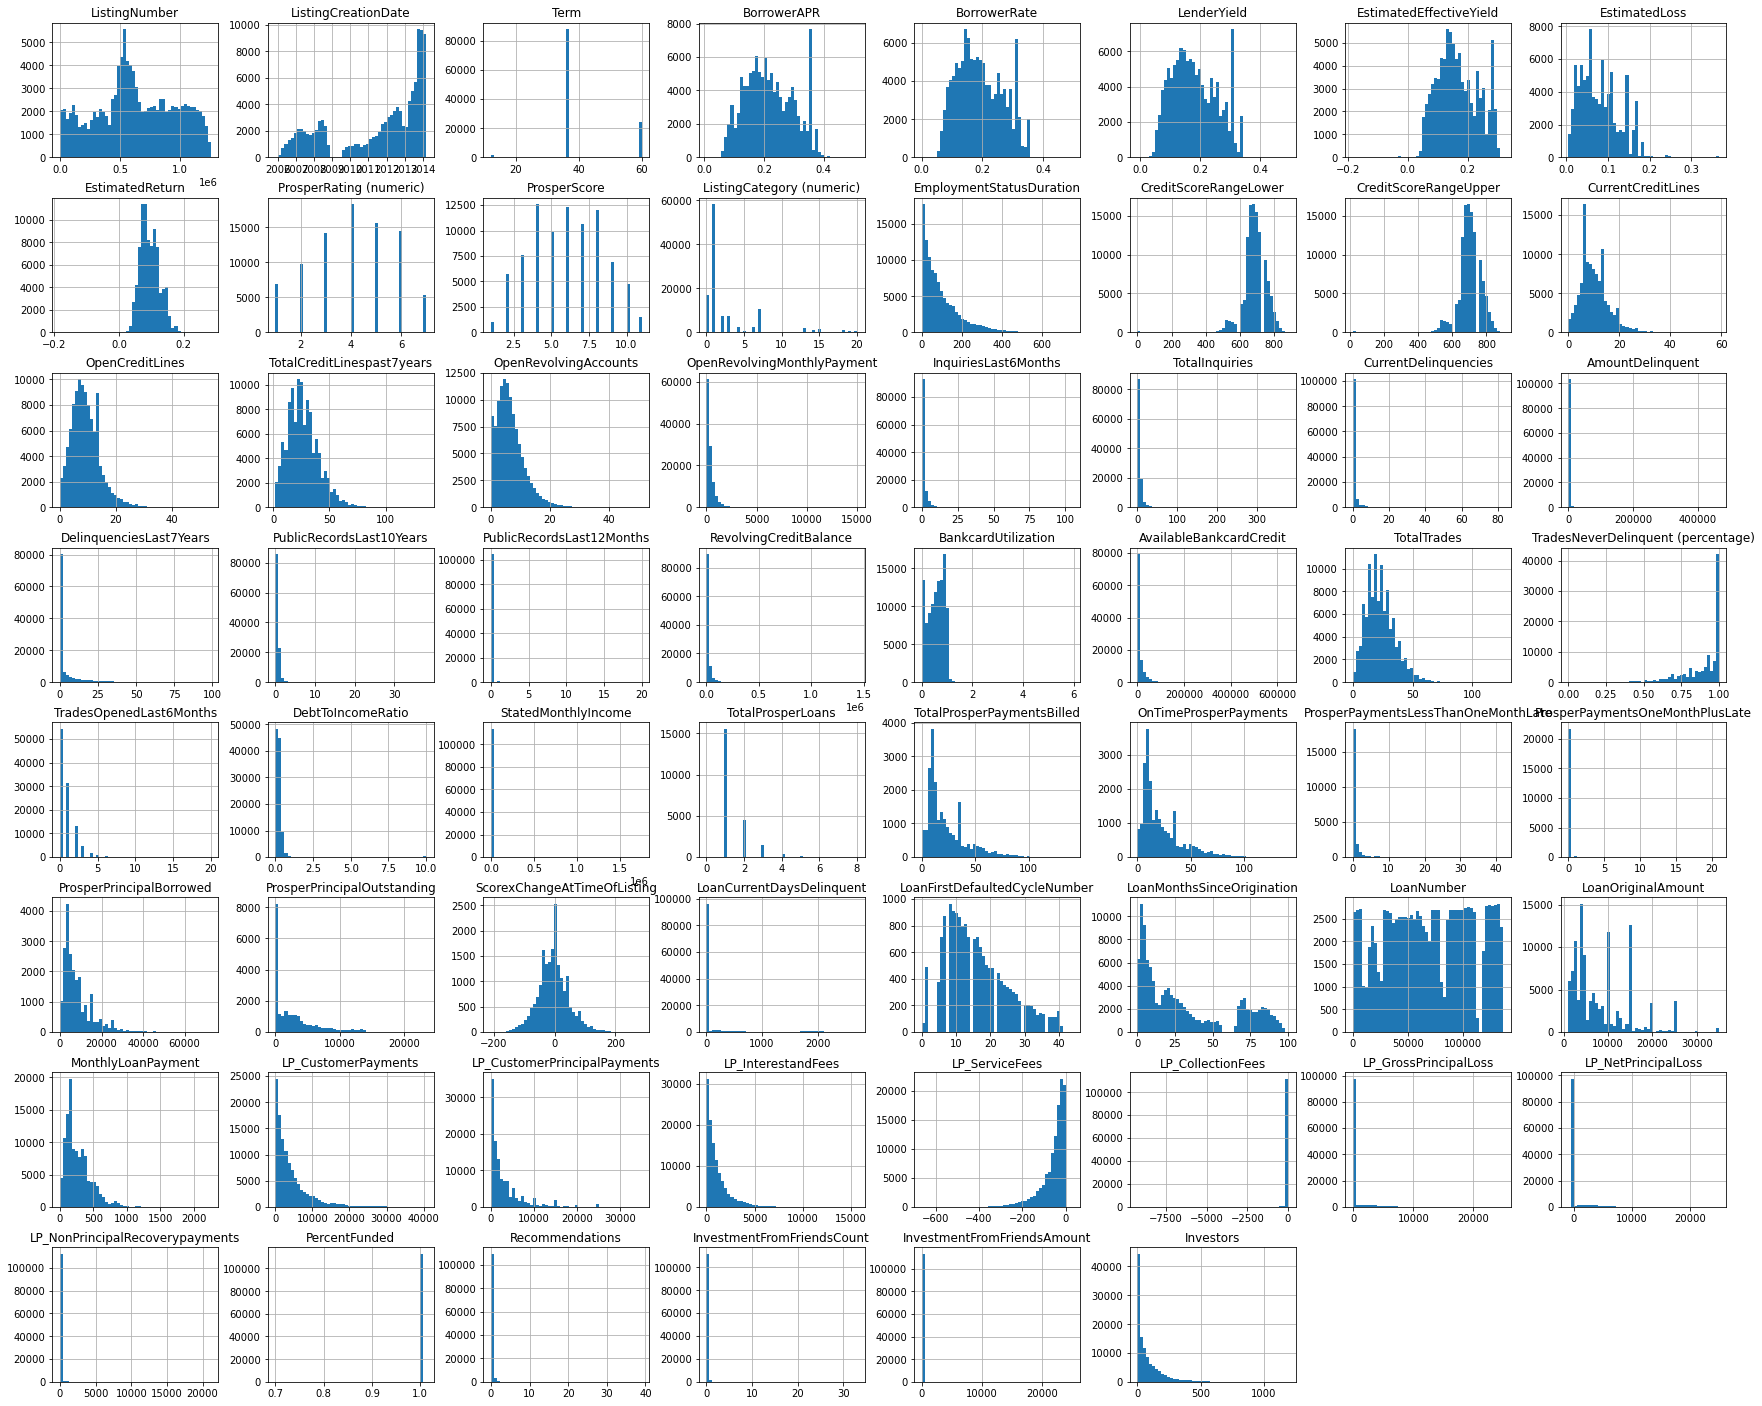

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt


prosper.hist(bins=50, figsize=(30,25))

plt.show()

We are plotting a Histogram for all the numerical attributes in the dataset in order to see the number of instances of a given attribute within a value range (horizental axis):
- The first thing to notice is that the variable "ListingNumber" is defined in the variable definition list of features as a unique ID number that identifies the listing publicly. We therefore must not use it as part of our features in the models.

- The variables "EstimatedLoss", "EstimatedReturn", and "EstimatedEffectiveYield" seem to be quiet useful for the model at first. However, after checking the data dictionary, we realized that those features were only valid for listings that came after July 2009. We discussed this with the team and thought it's not relevant to include them, because that would mean we must use only the post-2009 values, and we wouldn't have enough entries in terms of our target values to train our model correctly. Therefore, we didn't use them and chose to work with the whole dataset.

- Other observations to notice is that some values even though are numerical in nature, actually are categorical and we can spot them since they show up as bar plots rather than a continuous histogram, hence categories. "ProsperRating (numeric)", "ProsperScore", and "ListingCategory (numeric)" are some of the examples of those categorical features. We must not include them among the numerical features in our model.

- Some of the histograms are tail-heavy because they usually extand more to the right of the medium of the value range than to the left. As we can see, "EmploymentStatusDuration", "OpenCreditLines", "OpenRevolvingAccounts", "LP_customerPayments", "MonthlyLoanPayment" are some of the examples. This finding can make it harder for the Machine Learning models to detect patterns. Therefore, we can either omit them, or try transforming them into more of a bell-shaped distribution.

- Finally some histograms are too skewed to one side or one specific value, creating a heavy bias in our model so we decided not to inlude them. An example would be the "CurrentDelinquencies" and "ProsperPaymentsOneMonthPlusLate" features.

In [8]:
prosper = prosper.drop_duplicates()

In [9]:
prosper.corr()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
ListingNumber,1.000000,0.319971,-0.031520,-0.114391,-0.113544,-0.217721,-0.239568,-0.461391,0.209200,-0.106235,...,0.208286,0.104191,-0.251739,-0.247716,-0.096004,0.014688,-0.126031,-0.092813,-0.053481,-0.279659
Term,0.319971,1.000000,-0.011183,0.020085,0.020556,0.057047,-0.107140,0.152505,0.079179,0.028947,...,-0.167600,0.035841,-0.038353,-0.035981,-0.034157,-0.028806,-0.056680,-0.043507,-0.024472,-0.045137
BorrowerAPR,-0.031520,-0.011183,1.000000,0.989824,0.989329,0.895635,0.949538,0.794275,-0.962151,-0.668287,...,0.116974,-0.041452,0.067301,0.067385,0.028519,-0.028236,-0.044236,-0.046757,-0.031841,-0.307606
BorrowerRate,-0.114391,0.020085,0.989824,1.000000,0.999211,0.895282,0.945297,0.817670,-0.953105,-0.649736,...,0.095993,-0.053378,0.100635,0.100308,0.042059,-0.029025,-0.030579,-0.037312,-0.026512,-0.274217
LenderYield,-0.113544,0.020556,0.989329,0.999211,1.000000,0.895343,0.945308,0.817654,-0.953119,-0.649783,...,0.097854,-0.052954,0.099506,0.099195,0.041025,-0.029209,-0.031069,-0.037302,-0.026632,-0.274174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PercentFunded,0.014688,-0.028806,-0.028236,-0.029025,-0.029209,-0.043366,-0.022738,-0.039422,0.012491,-0.019344,...,0.069591,0.006186,-0.013144,-0.013578,0.000776,1.000000,0.009604,0.001622,0.003338,-0.049716
Recommendations,-0.126031,-0.056680,-0.044236,-0.030579,-0.031069,-0.046694,0.004081,-0.019886,0.004772,0.026658,...,-0.039016,-0.015910,0.041372,0.040897,0.016845,0.009604,1.000000,0.718079,0.322062,0.073824
InvestmentFromFriendsCount,-0.092813,-0.043507,-0.046757,-0.037312,-0.037302,-0.063848,0.009475,-0.043022,0.007746,0.028343,...,-0.035004,-0.008319,0.020932,0.020350,0.010109,0.001622,0.718079,1.000000,0.483506,0.058773
InvestmentFromFriendsAmount,-0.053481,-0.024472,-0.031841,-0.026512,-0.026632,-0.038146,0.024555,-0.031902,-0.010459,0.003131,...,-0.056675,-0.010141,0.028762,0.028301,0.018604,0.003338,0.322062,0.483506,1.000000,0.012178


In [10]:
prosper.dtypes

ListingKey                             object
ListingNumber                           int64
ListingCreationDate            datetime64[ns]
CreditGrade                            object
Term                                    int64
                                    ...      
PercentFunded                         float64
Recommendations                         int64
InvestmentFromFriendsCount              int64
InvestmentFromFriendsAmount           float64
Investors                               int64
Length: 81, dtype: object

In [11]:
prosper.replace("FinalPaymentInProgress","Completed",inplace=True)

In [12]:
prosper.replace("Chargedoff","Defaulted",inplace=True)

In [13]:
prosper = prosper[prosper["LoanStatus"] != "Current"]

In [14]:
prosper = prosper[(prosper.LoanStatus == "Defaulted") | (prosper.LoanStatus == "Completed")]\
    .drop(columns=("LP_CustomerPayments"))
prosper

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.00,0.00,0.00,1.0,0,0,0.0,258
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.00,0.00,0.00,1.0,0,0,0.0,41
11,0F1734025150298088A5F2B,213551,2007-10-09 20:28:33.640,C,36,Completed,2008-01-07 00:00:00,0.15033,0.1325,0.1225,...,-0.88,0.0,0.00,0.00,0.00,1.0,0,0,0.0,53
15,0F483544120452347F48121,577164,2012-04-10 09:14:46.297,NaN,36,Defaulted,2012-12-19 00:00:00,0.35797,0.3177,0.3077,...,-9.81,0.0,3790.25,3790.25,0.00,1.0,0,0,0.0,10
17,0FDF336575182398852A8DC,31540,2006-08-15 12:21:09.433,AA,36,Defaulted,2008-05-22 00:00:00,0.13202,0.1250,0.1175,...,-54.61,0.0,6012.65,6012.67,268.96,1.0,0,0,0.0,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113927,E3433419834735803891976,322787,2008-04-30 21:25:19.670,AA,36,Completed,2011-05-09 00:00:00,0.07469,0.0679,0.0579,...,-68.47,0.0,0.00,0.00,0.00,1.0,2,0,0.0,194
113928,E34935176664905343E01EA,510097,2011-06-06 19:02:44.443,NaN,36,Completed,2011-09-19 00:00:00,0.22362,0.1899,0.1799,...,-4.41,0.0,0.00,0.00,0.00,1.0,0,0,0.0,25
113929,E3553583161337791FCB87F,830413,2013-07-06 17:40:01.657,NaN,36,Completed,2014-02-07 00:00:00,0.30285,0.2639,0.2539,...,-6.54,0.0,0.00,0.00,0.00,1.0,0,0,0.0,26
113933,E6DB353036033497292EE43,537216,2011-11-03 20:42:55.333,NaN,36,Completed,NaN,0.13220,0.1110,0.1010,...,-30.05,0.0,0.00,0.00,0.00,1.0,0,0,0.0,22


In [15]:
prosper.groupby("LoanStatus").count()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
LoanStatus,,,,,,,,,,,,,,,,,,,,,
Completed,38279,38279,38279,18288,38279,38074,38254,38279,38279,19869,...,38279,38279,38279,38279,38279,38279,38279,38279,38279,38279
Defaulted,17010,17010,17010,10660,17010,17010,17010,17010,17010,6341,...,17010,17010,17010,17010,17010,17010,17010,17010,17010,17010


Categorical Feature Selection:

We have a lot of categorical features in our prosper dataset, and it would be useful to use as much of them as possible to have a chance at picking up more patterns. The problem that arises from this approach however is that it would take a lot of time, and computational power to run the models since we will eventually need to encode the categorical features to fit them into a vector to feed our machine learning models. Using the onehotencoder for example, a categorical feature that has 10 different classes would add up 10 columns to the vecotr matrix, and similarly with other categorical features, this would make the matrix longer and therefore high computation and slow running.

We decided to run Pearson's Chi-Square test because it proves usful and fit to measure independence between categorical variables:

BorrowerState: 130.128869
ListingCategory (numeric): 535.735425
Occupation: 472.012391
EmploymentStatus: 444.377537
IsBorrowerHomeowner: 16.740478
CurrentlyInGroup: 321.418340
IncomeVerifiable: 2.313215
IncomeRange: 16.242507


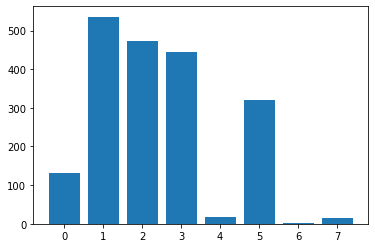

In [21]:
list_categories = ['BorrowerState', 'ListingCategory (numeric)', 'Occupation','EmploymentStatus','IsBorrowerHomeowner',\
                                     'CurrentlyInGroup','IncomeVerifiable', 'IncomeRange']
xx = prosper[list_categories].values
yy = prosper[["LoanStatus"]].values

# prepare input data
def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc
 
# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc
 
# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

    # split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train.ravel(), y_test.ravel())

X_train_enc_u = np.nan_to_num(X_train_enc)
X_test_enc_u = np.nan_to_num(X_test_enc)
np.isnan(X_test_enc_u).any()

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc_u, y_train_enc, X_test_enc_u)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('%s: %f' % (list_categories[i], fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

We can see that out of the categorical features chosen, "ListingCategory (Numeric)", "Occupation", "EmploymentStatus", and "CurrentlyInGroup" are the most useful categorical features based on the high score. "BorrowerState" can also be included but it might not be as relevant as the other chosen features.

In [16]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [ ]:
#numeric_features = list(prosper[['BorrowerAPR',\
                                 'BorrowerRate','LenderYield',\
                                 'CreditScoreRangeLower','CreditScoreRangeUpper','CurrentCreditLines',\
                                 'OpenCreditLines','TotalCreditLinespast7years','OpenRevolvingAccounts',\
                                 'BankcardUtilization', "TotalTrades", 'LoanMonthsSinceOrigination',\
                                 'LoanOriginalAmount','MonthlyLoanPayment','LP_CustomerPrincipalPayments',\
                                 'Investors']])

In [17]:
numeric_features = list(prosper[['BorrowerAPR',\
                                 'BorrowerRate','LenderYield',\
                                 'CreditScoreRangeLower','CreditScoreRangeUpper','CurrentCreditLines',\
                                 'OpenCreditLines','TotalCreditLinespast7years','OpenRevolvingAccounts',\
                                 'BankcardUtilization', "TotalTrades", 'LoanMonthsSinceOrigination',\
                                 'LoanOriginalAmount','MonthlyLoanPayment', 'LP_CustomerPrincipalPayments',\
                                 'Investors']])

In [17]:
#numeric_features = list(prosper[['BorrowerAPR',\
                                 'BorrowerRate','LenderYield',\
                                 'CreditScoreRangeLower','CreditScoreRangeUpper','CurrentCreditLines',\
                                 'OpenCreditLines','TotalCreditLinespast7years','OpenRevolvingAccounts',\
                                 'BankcardUtilization', "TotalTrades",\
                                 'TotalProsperPaymentsBilled','OnTimeProsperPayments',\
                                 'ProsperPrincipalBorrowed',\
                                 'ProsperPrincipalOutstanding','ScorexChangeAtTimeOfListing','LoanMonthsSinceOrigination',\
                                 'LoanOriginalAmount','MonthlyLoanPayment',\
                                 'Investors']])

In [18]:
categorical_features = list(prosper[['ListingCategory (numeric)', 'Occupation','EmploymentStatus',\
                                     'CurrentlyInGroup']])

#categorical_features = list(prosper[['ListingCategory (numeric)', 'Occupation','EmploymentStatus',\
 #                                    'CurrentlyInGroup']])

#8 Categorical Vars

#### Here we are building our first pipeline

In [19]:
numeric_pipeline = Pipeline(steps=[
    ('selector', DataFrameSelector(numeric_features)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


categorical_pipeline = Pipeline([
        ('selector', DataFrameSelector(categorical_features)),
        ('cat_encoder', OneHotEncoder(sparse=False,
                                      handle_unknown='ignore')),
    ])



full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", numeric_pipeline),
        ("cat_pipeline", categorical_pipeline),
    ])

from sklearn.compose import ColumnTransformer

full_pipeline2 = ColumnTransformer([
        ("num_pipeline", numeric_pipeline, numeric_features ),
        ("cat_pipeline", categorical_pipeline, categorical_features ),
    ])

In [20]:
train_set, test_set = train_test_split(prosper, test_size=0.33, random_state=42)

In [21]:
prosper_prepared = full_pipeline2.fit_transform(train_set)
len(prosper_prepared[1])

114

In [22]:
X_train = prosper_prepared

y_train = train_set[["LoanStatus"]].values.ravel()
y_train = (y_train == "Defaulted").astype(int)


In [23]:
y_train

array([1, 0, 0, ..., 0, 0, 0])

In [24]:
test_prepared = full_pipeline2.fit_transform(test_set)

X_test = test_prepared

y_test = test_set[["LoanStatus"]].values.ravel()
y_test = (y_test == "Defaulted").astype(int)



In [25]:
len(prosper_prepared[1])

114

In [26]:
#X_train = prosper_prepared

#y_train = train_set[["LoanStatus"]].values.ravel()
#y_train = (y_train == "Defaulted").astype(int)

clf = LogisticRegressionCV(cv=5, random_state=42, max_iter=1000).fit(X_train, y_train)

In [29]:
clf.score(X_train, y_train)

0.7266960019436871

In [30]:
len(X_train[1])

114

In [31]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82     25627
           1       0.60      0.33      0.42     11416

    accuracy                           0.73     37043
   macro avg       0.68      0.62      0.62     37043
weighted avg       0.71      0.73      0.70     37043



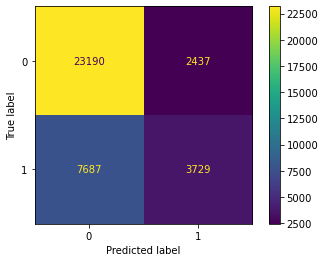

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_train, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

###### Results
Our model gives us some predictions but it can improve a lot. 
We would like to see fewer false negatives since those mean that the customer defaults but we predicted he/she wouldn't.

In [33]:
feature_names = np.array(numeric_features).view() 

In [34]:
def get_feature_names():  
        
        column_transformer = full_pipeline2 
        
        new_feature_names = np.insert(feature_names,0,'')

        for i, transformer_item in enumerate(column_transformer.transformers_):
            
            transformer_name, transformer, orig_feature_names = transformer_item
            orig_feature_names = list(orig_feature_names)
                
            if isinstance(transformer, Pipeline):
                # if pipeline, get the last transformer in the Pipeline
                transformer = transformer.steps[-1][1]

            if hasattr(transformer, 'get_feature_names'):

                if 'input_features' in transformer.get_feature_names.__code__.co_varnames:
                    names = list(transformer.get_feature_names(orig_feature_names))
                else:
                    names = list(transformer.get_feature_names())
                new_feature_names= np.append(new_feature_names,names)
                
        return new_feature_names

In [35]:
column_name = get_feature_names()
len(column_name)

/Users/bilalelahrach/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


116

#### Here we want to find the best hyperparameter for our model

In [36]:
log_reg = LogisticRegression(penalty='l1',solver="liblinear", random_state=42)

param_grid = [
    {'C': [0.001, 0.01, 0.1, 1]},
  ]

grid_search = GridSearchCV(log_reg, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best alpha value is: ", grid_search.best_params_)

Best alpha value is:  {'C': 1}


Classification report: 
 
                precision    recall  f1-score   support

           0       0.75      0.91      0.82     25627
           1       0.61      0.32      0.42     11416

    accuracy                           0.73     37043
   macro avg       0.68      0.62      0.62     37043
weighted avg       0.71      0.73      0.70     37043



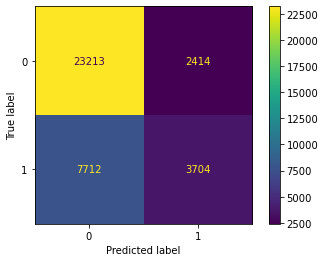

In [37]:
lg_reg = grid_search.best_estimator_

y_pred = lg_reg.predict(X_train)


cm = confusion_matrix(y_train, y_pred, labels=lg_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lg_reg.classes_)
disp.plot()

print("Classification report: \n \n ", classification_report(y_train, y_pred, zero_division=0))
plt.show()

In [38]:
len(X_train[1])

114

###### Results:
The model is now predicting 1789 true values but 2701 were predicted wrongly. 


In [39]:
## The code above will take a lot of time to be run

In [40]:
len(column_name)
len(numeric_features)

15

In [41]:
len(X_train[1])

114

Feature: BorrowerAPR, Score: -1.72781
Feature: BorrowerRate, Score: 3.08065
Feature: LenderYield, Score: -0.83855
Feature: CreditScoreRangeLower, Score: -0.27005
Feature: CreditScoreRangeUpper, Score: -0.11146
Feature: CurrentCreditLines, Score: 0.00207
Feature: OpenCreditLines, Score: 0.13654
Feature: TotalCreditLinespast7years, Score: 0.17567
Feature: OpenRevolvingAccounts, Score: -0.12508
Feature: BankcardUtilization, Score: -0.07925
Feature: TotalTrades, Score: -0.17771
Feature: LoanMonthsSinceOrigination, Score: 0.30734
Feature: LoanOriginalAmount, Score: 0.11986
Feature: MonthlyLoanPayment, Score: 0.21079
Feature: Investors, Score: -0.02041
Feature: x0_0, Score: 0.00000
Feature: x0_1, Score: -0.10541
Feature: x0_2, Score: 0.04124
Feature: x0_3, Score: 0.18588
Feature: x0_4, Score: 0.05973
Feature: x0_5, Score: -0.23360
Feature: x0_6, Score: -0.26729
Feature: x0_7, Score: -0.13676
Feature: x0_8, Score: 0.41384
Feature: x0_9, Score: -0.12161
Feature: x0_10, Score: -0.31519
Feature:

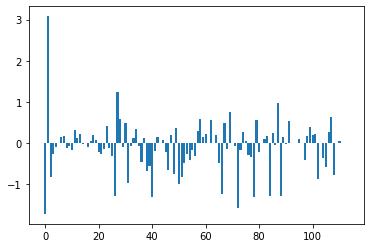

In [42]:
from matplotlib import pyplot
importance = lg_reg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (column_name[i+1],v))
        
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#### Now we want to see which features are important and weed out those that aren't

In [43]:
features = pd.DataFrame({'features': column_name[2:] , 'importance': list(importance)}, columns=['features', 'importance'])
## Negative importance coefficient also should be taken in consideration since it is somehow correlated negatively with the possibility of a user to apply for term deposit so :
features["importance"]= np.abs(features["importance"])
features = features.sort_values(by=['importance'], ascending=False)
features
Unimportante_features = features[features["importance"]==0]["features"].array
len(Unimportante_features)


9

In [44]:
for j in Unimportante_features:
    for i in numeric_features:
        if i == j:
            numeric_features.remove(i)

In [45]:
for j in Unimportante_features:
    for i in categorical_features:
        if i == j:
            categorical_features.remove(i)

In [46]:
len(numeric_features)

15

In [47]:
len(categorical_features)

4

In [48]:
len(X_train[1])

114

#### Now we create the pipeline and only use the important features

In [49]:
numeric_pipeline = Pipeline(steps=[
    ('selector', DataFrameSelector(numeric_features)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


categorical_pipeline = Pipeline([
        ('selector', DataFrameSelector(categorical_features)),
        ('cat_encoder', OneHotEncoder(sparse=False,
                                      handle_unknown='ignore')),
    ])



full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", numeric_pipeline),
        ("cat_pipeline", categorical_pipeline),
    ])

from sklearn.compose import ColumnTransformer

full_pipeline2 = ColumnTransformer([
        ("num_pipeline", numeric_pipeline, numeric_features ),
        ("cat_pipeline", categorical_pipeline, categorical_features ),
    ])

In [50]:
prosper_prepared = full_pipeline2.fit_transform(train_set)
X_train = prosper_prepared

In [51]:
len(X_train[1])

114

In [52]:
y_train = train_set[["LoanStatus"]].values.ravel()
y_train = (y_train == "Defaulted").astype(int)


clf = LogisticRegressionCV(cv=5, random_state=42, max_iter=5000).fit(X_train, y_train)
clf.score(X_train, y_train)

0.7266960019436871

In [53]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82     25627
           1       0.60      0.33      0.42     11416

    accuracy                           0.73     37043
   macro avg       0.68      0.62      0.62     37043
weighted avg       0.71      0.73      0.70     37043



In [56]:
len(X_train[1])

114

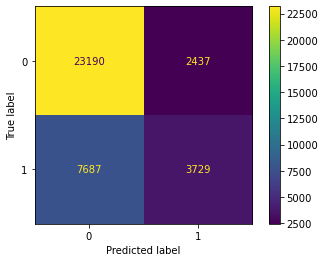

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_train, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

###### Results:
Bearly any change

In [58]:
column_name = get_feature_names()

/Users/bilalelahrach/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Now we want to find the best hyperparameter

In [59]:
log_reg = LogisticRegression(penalty='l1',solver="liblinear", random_state=42, max_iter= 5000)

param_grid = [
    {'C': [0.001, 0.01, 0.1, 1]},
  ]

grid_search = GridSearchCV(log_reg, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best alpha value is: ", grid_search.best_params_)

Best alpha value is:  {'C': 1}


In [60]:
len(X_train[1])

114

Classification report: 
 
                precision    recall  f1-score   support

           0       0.91      0.75      0.82     30925
           1       0.32      0.61      0.42      6118

    accuracy                           0.73     37043
   macro avg       0.62      0.68      0.62     37043
weighted avg       0.81      0.73      0.76     37043



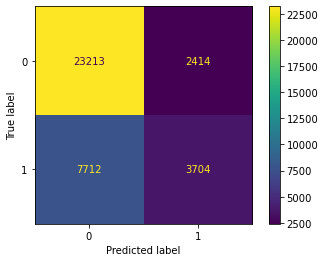

In [61]:
lg_reg = grid_search.best_estimator_

y_pred = lg_reg.predict(X_train)


cm = confusion_matrix(y_train, y_pred, labels=lg_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lg_reg.classes_)
disp.plot()

print("Classification report: \n \n ", classification_report(y_pred, y_train))
plt.show()

###### Results:
The model result still did not change a lot 


Feature: BorrowerAPR, Score: -1.72781
Feature: BorrowerRate, Score: 3.08065
Feature: LenderYield, Score: -0.83855
Feature: CreditScoreRangeLower, Score: -0.27005
Feature: CreditScoreRangeUpper, Score: -0.11146
Feature: CurrentCreditLines, Score: 0.00207
Feature: OpenCreditLines, Score: 0.13654
Feature: TotalCreditLinespast7years, Score: 0.17567
Feature: OpenRevolvingAccounts, Score: -0.12508
Feature: BankcardUtilization, Score: -0.07925
Feature: TotalTrades, Score: -0.17771
Feature: LoanMonthsSinceOrigination, Score: 0.30734
Feature: LoanOriginalAmount, Score: 0.11986
Feature: MonthlyLoanPayment, Score: 0.21079
Feature: Investors, Score: -0.02041
Feature: x0_0, Score: 0.00000
Feature: x0_1, Score: -0.10541
Feature: x0_2, Score: 0.04124
Feature: x0_3, Score: 0.18588
Feature: x0_4, Score: 0.05973
Feature: x0_5, Score: -0.23360
Feature: x0_6, Score: -0.26729
Feature: x0_7, Score: -0.13676
Feature: x0_8, Score: 0.41384
Feature: x0_9, Score: -0.12161
Feature: x0_10, Score: -0.31519
Feature:

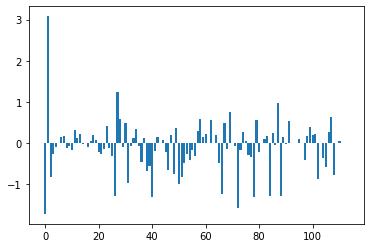

In [64]:
from matplotlib import pyplot
importance = lg_reg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (column_name[i+1],v))
        
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#### Here we want to see how both the Precision and the Recall change depending on which threshold we use

114


(0.0, 1.0)

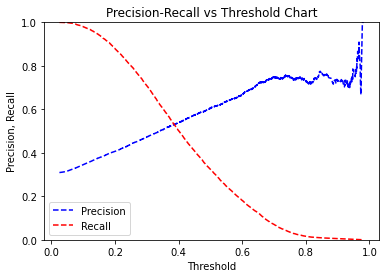

In [65]:
### Predict test_y values and probabilities based on fitted logistic regression model
from sklearn import metrics
predTest = lg_reg.predict(X_train)
print(len(X_train[1]))

probs_y=lg_reg.predict_proba(X_train) 
# probs_y is a 2-D array of probability of being labeled as 0 (first column of array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve


precision, recall, thresholds = precision_recall_curve(y_train, probs_y[:, 1]) 
#retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

#### We need to interpret this 


#### Here we plot the ROC curve

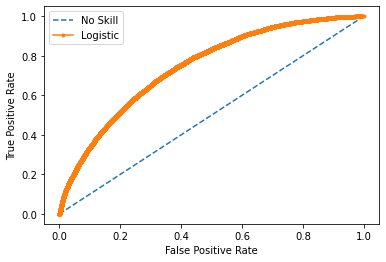

In [66]:
# roc curve for logistic regression model
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# predict probabilities
yhat =lg_reg.predict_proba(X_train) 
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

##Running the example fits a logistic regression model on the training dataset 
##Then evaluates it using a range of thresholds on the test set, creating the ROC Curve

#### From the ROC curve we choose the best Threshold


In [67]:
from numpy import * 
yhat = lg_reg.predict_proba(X_train)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold= %f' % (best_thresh))

Best Threshold= 0.302795


In [68]:
len(X_train[1])

114

In [69]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score, classification_report
THRESHOLD = best_thresh
preds = np.where(lg_reg.predict_proba(X_train)[:,1] > THRESHOLD, 1, 0)

In [70]:
print(classification_report(y_train,preds))

              precision    recall  f1-score   support

           0       0.83      0.65      0.73     25627
           1       0.47      0.70      0.57     11416

    accuracy                           0.67     37043
   macro avg       0.65      0.68      0.65     37043
weighted avg       0.72      0.67      0.68     37043



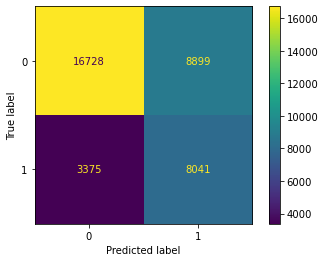

In [71]:
CM = confusion_matrix(y_train, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=lg_reg.classes_)
disp.plot()
plt.show()

###### Results:
Here we see an improvement. We have decrease our main evaluation criteria: False Negatives.
That means that fewer people are defaulting that we did not predict that would default. We are still predicting a lot of clients to default that would not default

#### Now we will run the model using the test dataset


We use fit_transform() on the train data so that we learn the parameters of scaling on the train data and in the same time we scale the train data. We only use transform() on the test data because we use the scaling paramaters learned on the train data to scale the test data.

In [72]:
#This is a random thought about the date
#train_set["ListingCreationDate"]
#for column in train_set:
#    print(train_set[column].values)

In [73]:
bank_prepared2 = full_pipeline2.transform(test_set)
bank_prepared2.shape

(18246, 114)

In [74]:
bank_prepared2

array([[ 0.2265758 ,  0.20768727,  0.21080281, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.44309574,  0.46737364,  0.47225972, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.82484262,  0.97197748,  0.98030394, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.50006272,  0.71721408,  0.72380357, ...,  0.        ,
         1.        ,  0.        ],
       [-0.20691798, -0.40768328, -0.40876331, ...,  0.        ,
         1.        ,  0.        ],
       [-0.59195579, -0.64029334, -0.64295931, ...,  0.        ,
         1.        ,  0.        ]])

In [75]:
bank_prepared2test = full_pipeline2.fit_transform(test_set)
bank_prepared2test.shape

(18246, 115)

In [76]:
#column_name

In [77]:
column_name1 = get_feature_names()
#column_name1

/Users/bilalelahrach/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [78]:
Missing_value  = ""
for i in range(len(column_name1)):
    if column_name1[i] not in column_name:
        print(column_name1[i])
        Missing_value = column_name1[i]
        

x1_Judge


In [79]:
col_name = np.asarray(column_name1)
#col_name.index(Missing_value)
pos = np.where(col_name == Missing_value)[0][0]

In [80]:
rows = bank_prepared2test.shape[0]

In [81]:
bank_list = bank_prepared2test.tolist()

In [82]:
bank_prepared2test
for i in range(rows):
    bank_list[i].pop(pos)

In [83]:
#### testing with logistic regression
#bank_prepared2 = full_pipeline2.fit_transform(test_set)

X_test = bank_list
y_test = test_set[["LoanStatus"]].values.ravel()
y_test = (y_test == "Defaulted").astype(int)
predTest = lg_reg.predict(X_test)



              precision    recall  f1-score   support

           0       0.90      0.75      0.82     15217
           1       0.32      0.58      0.41      3029

    accuracy                           0.72     18246
   macro avg       0.61      0.67      0.61     18246
weighted avg       0.80      0.72      0.75     18246



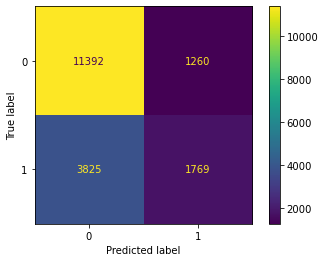

In [84]:
print(classification_report(predTest, y_test))
CM = confusion_matrix(y_test, predTest, labels=lg_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=lg_reg.classes_)
disp.plot()
plt.show()

###### Results:
Our model performs well on the test set. The model predictions are good, but could be better.

#### Now we change the threshold for the model

              precision    recall  f1-score   support

           0       0.65      0.82      0.72      9974
           1       0.68      0.46      0.55      8272

    accuracy                           0.66     18246
   macro avg       0.66      0.64      0.64     18246
weighted avg       0.66      0.66      0.64     18246



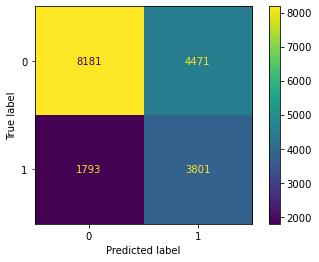

In [85]:
#### after changing the threshold with the test set
preds = np.where(lg_reg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
print(classification_report(preds, y_test))
CM = confusion_matrix(y_test, preds, labels=lg_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=lg_reg.classes_)
disp.plot()
plt.show()

###### Results:
By changing the threshold our model performs even better. We see very few false negatives.

#### Now we'll build a random forest model

In [86]:
###########Random forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, n_estimators=10, random_state= 42)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=2, n_estimators=10, random_state=42)

#### We use the ROC curve to find the best threshold

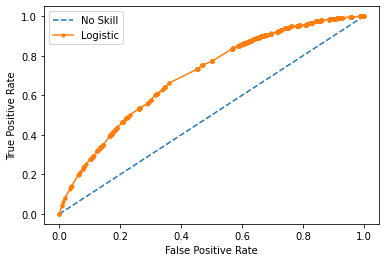

New threshold :  0.3109998950648917




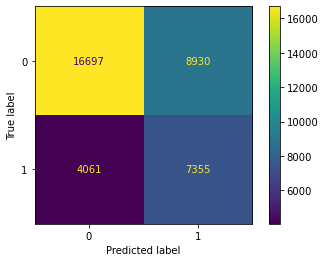

In [87]:
from numpy import * 
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score, classification_report

y_train = train_set[["LoanStatus"]].values.ravel()
y_train = (y_train == "Defaulted").astype(int)
y_pred= rf.predict(X_train)

yhat = rf.predict_proba(X_train)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
THRESHOLD1 = best_thresh
print("New threshold : ", THRESHOLD1)
print("\n")
preds = np.where(rf.predict_proba(X_train)[:,1] > THRESHOLD1, 1, 0)
CM = confusion_matrix(y_train, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=rf.classes_)
disp.plot()
plt.show()

###### Results:
Our random forest model performs even better then the logistic regression model. Only a fraction of the predictions are false negatives. On the otherhand, our model is predicting a lot of false positives.

#### Here we'll use our model on the test dataset

(0.0, 1.0)

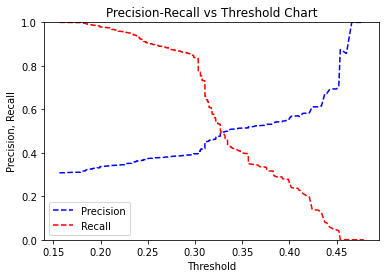

In [88]:
### Predict test_y values and probabilities based on fitted random forest model
from sklearn import metrics
predTest = rf.predict(X_train)

probs_y= rf.predict_proba(X_train) 
# probs_y is a 2-D array of probability of being labeled as 0 (first column of array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve


precision, recall, thresholds = precision_recall_curve(y_train, probs_y[:, 1]) 
#retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [89]:
print("Classification report: \n \n ", classification_report(y_train, y_pred ,zero_division=0 ))

Classification report: 
 
                precision    recall  f1-score   support

           0       0.69      1.00      0.82     25627
           1       0.00      0.00      0.00     11416

    accuracy                           0.69     37043
   macro avg       0.35      0.50      0.41     37043
weighted avg       0.48      0.69      0.57     37043



              precision    recall  f1-score   support

           0       1.00      0.69      0.82     18246
           1       0.00      0.00      0.00         0

    accuracy                           0.69     18246
   macro avg       0.50      0.35      0.41     18246
weighted avg       1.00      0.69      0.82     18246



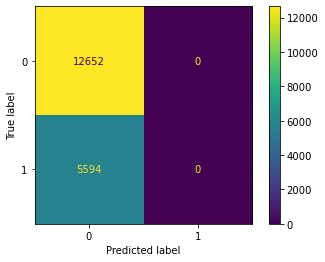

In [90]:
#### testing with random forest

bank_prepared2 = full_pipeline2.fit_transform(test_set)

X_test = bank_list
y_test = test_set[["LoanStatus"]].values.ravel()
y_test = (y_test == "Defaulted").astype(int)
predTest = rf.predict(X_test)

print(classification_report(predTest, y_test,zero_division=0))
CM = confusion_matrix(y_test, predTest, labels=lg_reg.classes_, )
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=lg_reg.classes_)
disp.plot()
plt.show()

###### Results:
The predictions are poor. Our model does not make any default predictions. This model is not helpful.

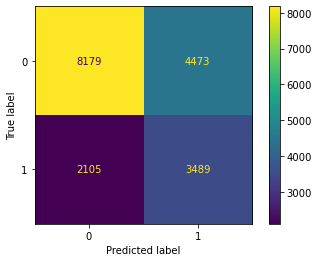

In [91]:
#### after changing the threshold with the test set
preds = np.where(rf.predict_proba(X_test)[:,1] > THRESHOLD1, 1, 0)
CM = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=rf.classes_)
disp.plot()
plt.show()

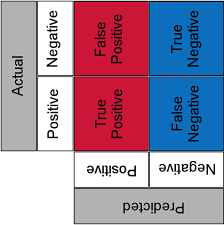

In [92]:
from IPython import display
display.Image("./download.png")

###### Results:

0: completed
1: defaulted

After changing the threshold our model performs very well on the test data. We have 0 false negatives which is our focus since having false negative will cost Prosper more than having false positive. At the same time, we can still improve on not predicting false positives (6382).

## Trying principal component analysis PCA for dimentionality reduction

Large number of features in the dataset is one of the factors that affect both the training time as well as accuracy of machine learning models. You have different options to deal with huge number of features in a dataset.

1- Try to train the models on original number of features, which take days or weeks if the number of features is too high.

2- Reduce the number of variables by merging correlated variables.

3- Extract the most important features from the dataset that are responsible for maximum variance in the output. Different statistical techniques are used for this purpose e.g. linear discriminant analysis, factor analysis, and principal component analysis.

### Advantages of PCA

There are two main advantages of dimensionality reduction with PCA.

The training time of the algorithms reduces significantly with less number of features.

It is not always possible to analyze data in high dimensions. 

PCA performs best with a normalized feature set. We will perform standard scalar normalization to normalize our feature set. To do this, execute the following code:

In [93]:
train_set, test_set = train_test_split(prosper, test_size=0.33, random_state=42)

prosper_prepared = full_pipeline2.fit_transform(train_set)

X_train = prosper_prepared

y_train = train_set[["LoanStatus"]].values.ravel()
y_train = (y_train == "Defaulted").astype(int)


X_test = bank_list
y_test = test_set[["LoanStatus"]].values.ravel()
y_test = (y_test == "Defaulted").astype(int)


In [94]:
from sklearn.preprocessing import StandardScaler

#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)


In [95]:
X_train

array([[ 0.49881444,  0.3406073 ,  0.3446291 , ...,  0.        ,
         1.        ,  0.        ],
       [-0.21871991, -0.20338026, -0.20306736, ...,  0.        ,
         1.        ,  0.        ],
       [-0.70952112, -1.20274202, -1.20924275, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.12065934, -1.20643424, -1.21296015, ...,  0.        ,
         1.        ,  0.        ],
       [-1.09194888, -1.17566571, -1.18198184, ...,  0.        ,
         1.        ,  0.        ],
       [-1.21995438, -1.34181576, -1.3492647 , ...,  0.        ,
         1.        ,  0.        ]])

In [96]:
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

X_train.shape

(37043, 114)

In [97]:
X_test.shape

(18246, 114)

## Implementing RandomForestClassification with PCA
In this case we will use random forest classification for making the predictions.

Source: https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/

In [98]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=42)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

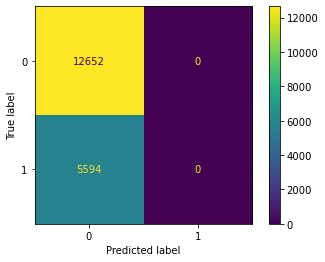

In [99]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#cm = confusion_matrix(y_test, y_pred)
#print(cm)
#print('Accuracy' , accuracy_score(y_test, y_pred))

CM = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels= classifier.classes_)
disp.plot()
plt.show()



## Findings:

Using PCA with random forest classifier gave us a good result for false positive (predicted defaulted but the loan was completed) while the false negative is high (predicted completed but the loan was defaulted) which is our focus. how can we improve our model ??

### Choosing the Right Number of Dimensions

In [100]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d


21

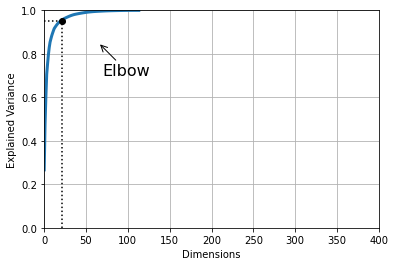

In [101]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [102]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
X_reduced.shape

(37043, 21)

In [103]:
####### Is there a way to know the name of chosen features 


classifier.fit(X_reduced, y_train)

# Predicting the Test set results
X_test_reduced = pca.fit_transform(X_test)
print(X_test_reduced.shape)


(18246, 20)


In [104]:
#### Not sure yet if this is true 
#### I will add the missing features and it will be the average of other features 
X_test_reduced_new = []
for i in range(X_test_reduced.shape[0]):
    X_test_reduced_new.append(np.append(X_test_reduced[i], average(X_test_reduced[i])))



In [105]:
X_test_reduced_new = np.asarray(X_test_reduced_new)
X_test_reduced_new.shape

(18246, 21)

In [106]:
y_pred = classifier.predict(X_test_reduced)

ValueError: X has 20 features, but RandomForestClassifier is expecting 21 features as input.

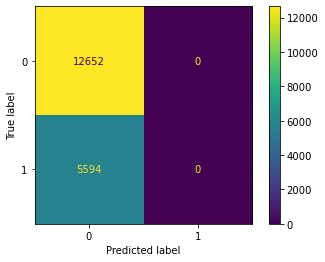

In [107]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

CM = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels= classifier.classes_)
disp.plot()
plt.show()

## Findings:

The model improved, but the logistic regression model is still unbeatable.

## Keras Deep Learning model 

In [102]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping

Source: https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

In [103]:
#We do not split to train and test 

prosper_prepared = full_pipeline2.fit_transform(prosper)

X = prosper_prepared
y = prosper[["LoanStatus"]].values.ravel()
y = (y == "Defaulted").astype(int)


In [104]:
X.shape

(55289, 120)

In [105]:
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [106]:
X_train_all.shape

(37043, 120)

In [107]:
X_valid, X_train = X_train_all[:4000], X_train_all[4000:] 
y_valid, y_train = y_train_all[:4000], y_train_all[4000:] 

In [109]:
# create model
model = Sequential()
model.add(Dense(120, input_dim=120, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Early stopping
es = EarlyStopping(monitor='val_recall', mode='max', verbose=1, patience=3)
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Recall'])
# Fit the model

#history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid), epochs=30, batch_size=10, callbacks=[es])
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid), epochs=30, batch_size=10)

Epoch 1/30
3305/3305 [==============================] - 5s 1ms/step - loss: 0.5424 - recall: 0.3266 - val_loss: 0.5291 - val_recall: 0.4813
Epoch 2/30
3305/3305 [==============================] - 4s 1ms/step - loss: 0.5288 - recall: 0.3424 - val_loss: 0.5241 - val_recall: 0.2914
Epoch 3/30
3305/3305 [==============================] - 4s 1ms/step - loss: 0.5221 - recall: 0.3479 - val_loss: 0.5221 - val_recall: 0.4246
Epoch 4/30
3305/3305 [==============================] - 4s 1ms/step - loss: 0.5161 - recall: 0.3883 - val_loss: 0.5187 - val_recall: 0.4105
Epoch 5/30
3305/3305 [==============================] - 4s 1ms/step - loss: 0.5106 - recall: 0.3987 - val_loss: 0.5300 - val_recall: 0.3955
Epoch 6/30
3305/3305 [==============================] - 4s 1ms/step - loss: 0.5034 - recall: 0.4181 - val_loss: 0.5259 - val_recall: 0.4313
Epoch 7/30
3305/3305 [==============================] - 4s 1ms/step - loss: 0.4974 - recall: 0.4306 - val_loss: 0.5380 - val_recall: 0.5154
Epoch 8/30
3305/3305

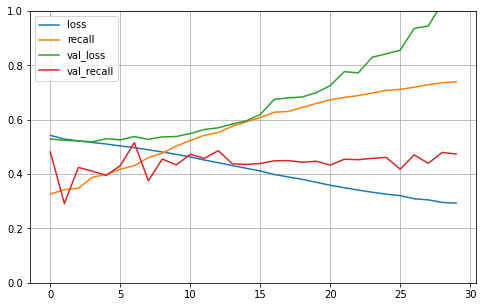

In [110]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.show()

In [111]:
model.evaluate(X_test, y_test)

571/571 [==============================] - 1s 993us/step - loss: 1.0091 - recall: 0.4510


[1.009131908416748, 0.45101895928382874]

## Testing the model

In [112]:
X_new = X_test[:10]
y_proba = model.predict(X_new)
y_proba.round(1)

array([[0. ],
       [0.7],
       [0.4],
       [0. ],
       [0.1],
       [0. ],
       [0.1],
       [0.3],
       [0.4],
       [0.6]], dtype=float32)

In [113]:
y_new = y_test[:10]
y_new

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1])